In [1]:
from power_spectra import * #look into this file. You need camb or class to get power spectra (there are wrapper functions for both). 
                            #The file imports both class and camb. Comment out relevant lines (at the top) if you don't have one of them.
from scipy.special import jn, jn_zeros
from scipy.interpolate import interp1d
from hankel_transform import *
from astropy.cosmology import Planck13 #use Planck15 if you can
import astropy.units as u
rc('text', usetex=False)
import scipy
from scipy.interpolate import interp1d

from projected_corr_rsd import *

from wigner_functions import wigner_d

In [2]:
def taper(k=[],pk=[],large_k_lower=10,large_k_upper=30,low_k_lower=1.e-4,low_k_upper=1.e-3):
    pk_out=np.copy(pk)
    x=k>large_k_lower
    pk_out[x]*=np.cos((k[x]-large_k_lower)/(large_k_upper-large_k_lower)*np.pi/2.)
    x=k>large_k_upper
    pk_out[x]=0
    x=k<low_k_upper
    pk_out[x]*=np.cos((k[x]-low_k_upper)/(low_k_upper-low_k_lower)*np.pi/2.)
    x=k<low_k_lower
    pk_out[x]=0
    return pk_out

In [3]:
cosmo=Planck13.clone()#we want h=1 for some comparisons
cosmo_h=Planck13.clone(H0=100)#we want h=1 for some comparisons

In [4]:
#set parameters for power spectra computations.
#play around with kmax,kmin to find optimal values for your case (based on rmin,rmax). 
#Remember very high kmax or very low kmin will require finer grid, slowing down the initial setup of the hankel transform. 
#Subsequent calculations of correlation functions are fast, so speed should not be major issue when running fits.
#need atleast k=10 and k=1.e-3 to get decent wgg for 1-100 Mpc/h range.
kmax=30
kmin=1.e-4
k_smooth=1
nk=8000
rmin=.1
rmax=100
non_linear=1

r_bins=np.logspace(-1,np.log10(100),21) #np.logspace(0,2,11)

In [5]:
cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'As':2.12e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,'w':-1,'wa':0})
pk_params={'non_linear':non_linear,'kmax':kmax,'kmin':kmin,'nk':nk}

In [6]:
PS=Power_Spectra(cosmo_params=cosmo_fid,pk_params=pk_params)

In [7]:
z_mean=0

In [8]:
pk,kh =PS.camb_pk(z=[z_mean])

In [9]:
pk=taper(k=kh,pk=pk[0])

In [10]:
pcr=Projected_Corr_RSD(rp=r_bins,pi_max=100,l=[0,2,4,6],k=kh,spins=[0,2])

/home/deep/repos/Public-code/Hankel_transform/wigner_functions.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  d_mat/=np.sqrt(binom(k+b,b))
/usr/local/lib/python3.9/dist-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


In [11]:
r,xi=pcr.get_xi_multipole(pk=pk,l=[0,2,4])

/usr/local/lib/python3.9/dist-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


(1, 100)

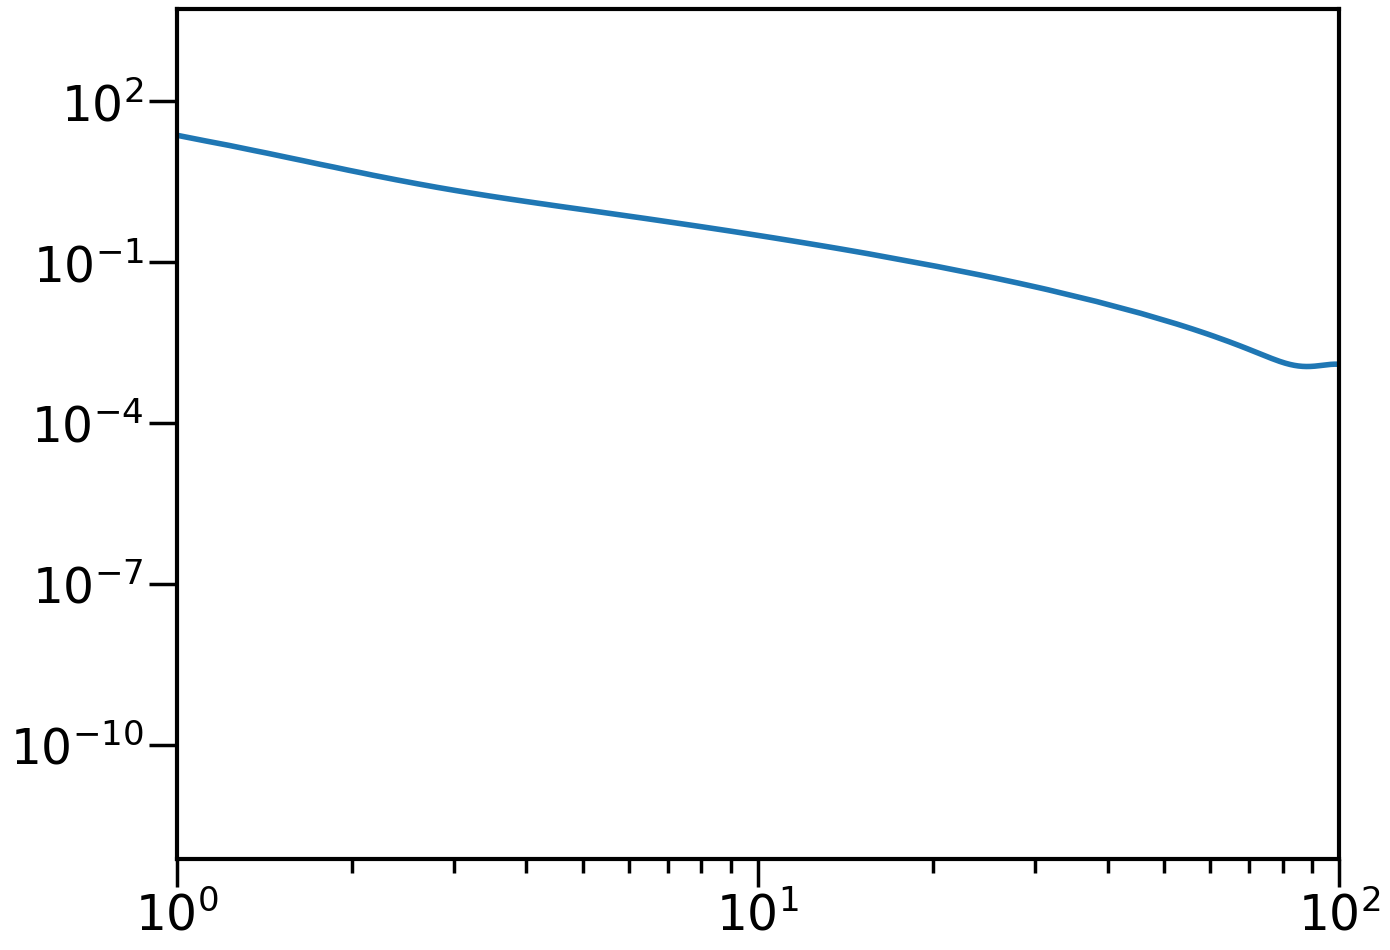

In [12]:
i=0
plot(r[i],xi[i])
loglog()
xlim(1,100)

In [13]:
rp=np.linspace(.1,100,500)
pi=np.linspace(0,100,499)
pi2=np.append(-pi[::-1],pi)

In [14]:
# g+ spin 2, l=[2,4] 
xigp_rp_pi_pcr=pcr.xi_rp_pi(f=0.66,bg1=2,pk=pk,l=[2,4],spin=2,rp=rp,pi=pi2)

/usr/local/lib/python3.9/dist-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [15]:
# gg spin 0, l=[0,2,4] 
xigg_rp_pi_pcr=pcr.xi_rp_pi(f=0.66,bg1=2,pk=pk,l=[0,2,4],spin=0,rp=rp,pi=pi2)

In [16]:
colors=['r','b','g','m','c']


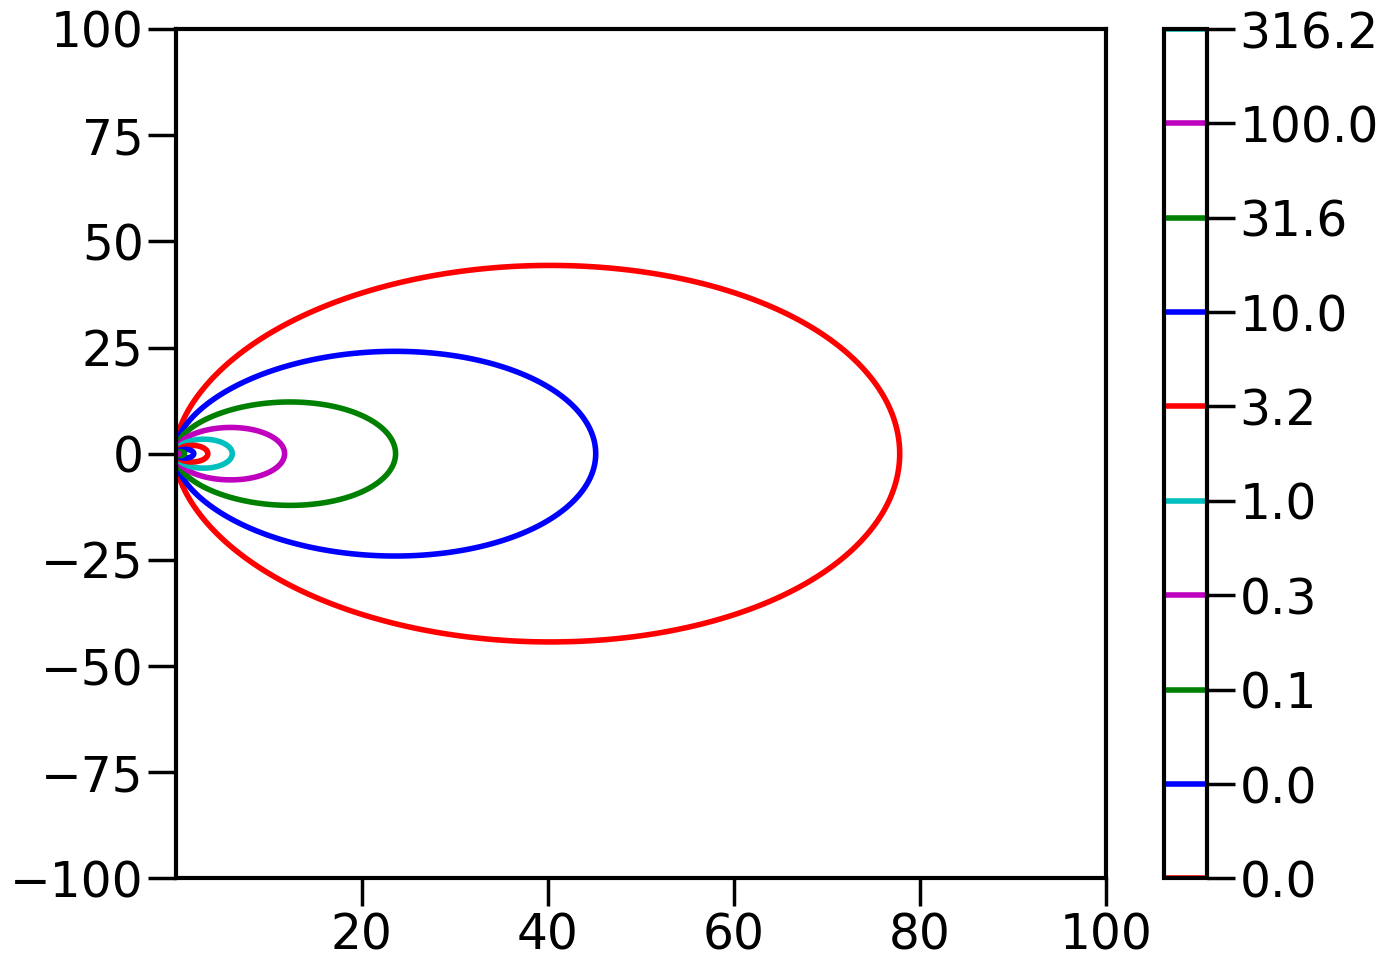

In [17]:
ll=np.logspace(-2,2.5,10)
contour(rp,pi2,xigp_rp_pi_pcr,levels=ll,colors=colors)
# xscale('log')
# yscale('log')
colorbar()

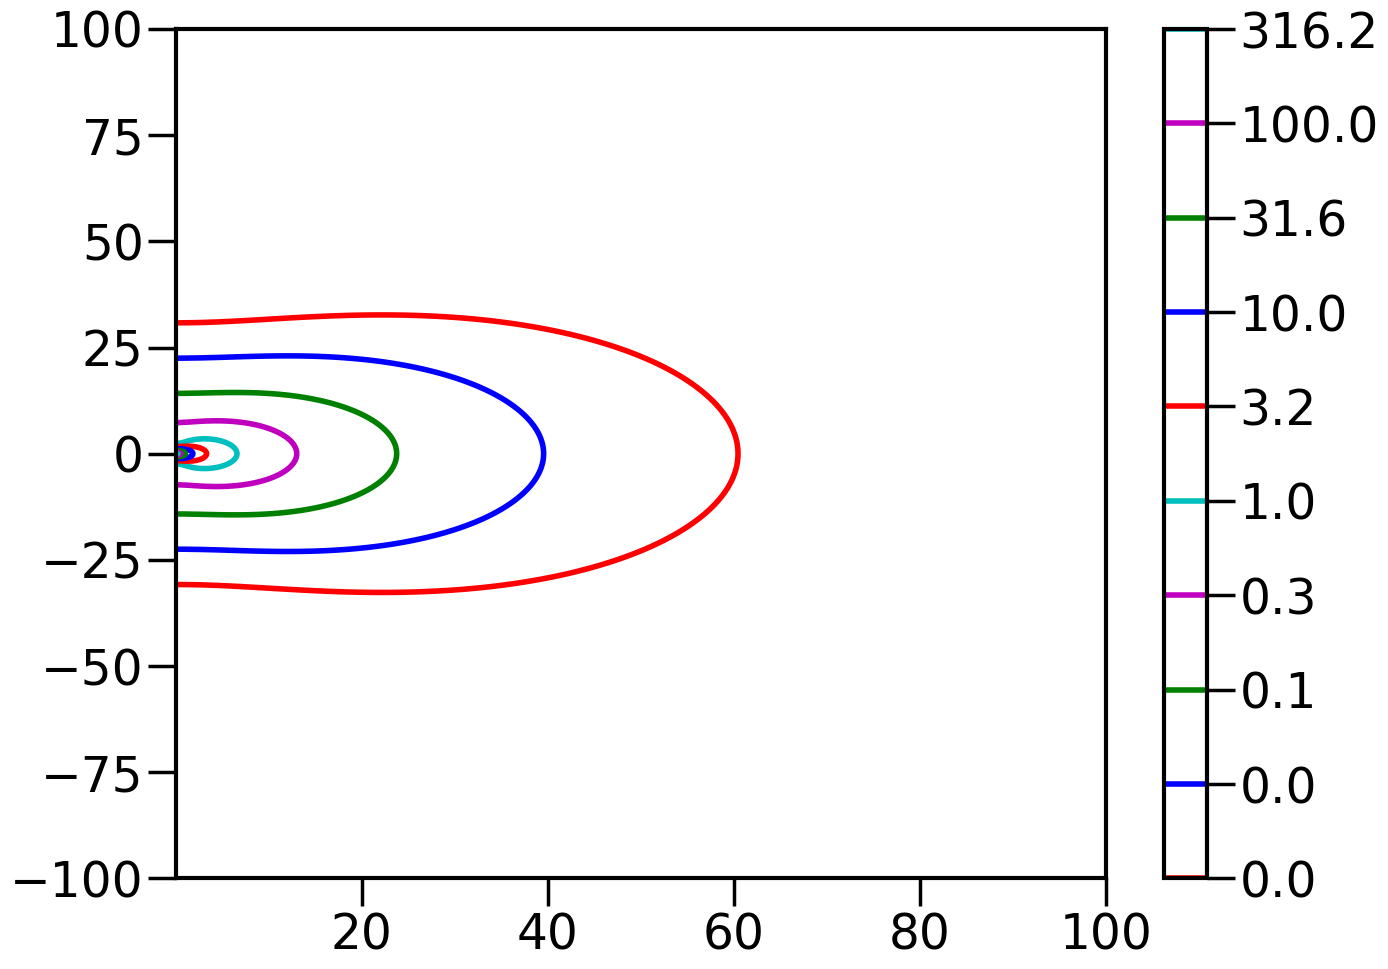

In [18]:
contour(rp,pi2,xigg_rp_pi_pcr,levels=ll,colors=colors)
# xscale('log')
# yscale('log')
colorbar()

# Eqns

$w_{g+}$ involves spin-2 objects and we need to use the associated legendre polynomials. 

$P_{\ell,m} = (-1)^m (1-x^2)^{m/2}\frac{\partial^m P_\ell(x)}{\partial x^m}$ [link](https://en.wikipedia.org/wiki/Associated_Legendre_polynomials)

$m=2$  

$P_{0,2} = 0$  [Link to Legendre Polynomials expressions used](https://en.wikipedia.org/wiki/Legendre_polynomials)

$P_{2,2} = (1-x^2)\frac{\partial^2 (\frac{1}{2}(3x^2-1))}{\partial x^2} =(1-x^2)(3) $ 

$P_{4,2} = (1-x^2)\frac{\partial^2 (\frac{1}{8}(35x^4-30x^2+3))}{\partial x^2}  = (1-x^2) \frac{1}{8}(12.35x^2-60) = \frac{1}{2}(1-x^2) (105x^2-15) = \frac{1}{2} (-105x^4+120x^2-15)$

$P_{6,2} = (1-x^2)\frac{\partial^2 (\frac{1}{16}(231x^6-315x^4+105x^2-5))}{\partial x^2} = (1-x^2)\frac{1}{8}(231.3.5.x^4-315.2.3.x^2+105) = \frac{1}{8} (-231.3.5.x^6 + 231.3.5.x^4 + 315.2.3x^4 - 315.2.3x^2 -105x^2+105)$

$d_{\ell,m,0} = \sqrt{\frac{(\ell-m)!}{(\ell+m)!}} P_{\ell,m}$ This is what we use to get $P_{\ell,m}$

Deriving the coefficients for multipoles (second/third equalities in a line depend on eqns in lower lines)

$(1+\beta_S\mu^2)(1+\beta_D\mu^2)=1+(\beta_S+\beta_D)\mu^2 + \beta_S\beta_D\mu^4 = \alpha_2 P_{2,2} + \alpha_4 P_{4,2}$


$\beta_S\beta_D=-105/2 \alpha_4 = -\beta_S-\beta_D -1$

$\beta_S+\beta_D=120/2 \alpha_4 - 3\alpha_2 = 105/2 \alpha_4 -1$

$1=-15/2\alpha_4+3\alpha_2$

$\beta_S=-1$. In this case, eqs. are consistent and we get:

$ \alpha_4 = \frac{2}{105}\beta_D$

$ \alpha_2= \frac{1}{3} (1+15/2\alpha_4)=\frac{1}{3} (1+\frac{1}{7}\beta_D)$

# Rough Space

In [ ]:
crash

In [13]:
theta=np.linspace(0,np.pi,100)

In [14]:
orders=[0,2,4]
L={order:legendre(order,np.cos(theta)) for order in orders}
W={order:wigner_d(2,0,theta,order+2) for order in orders}
W0={order:wigner_d(0,0,theta,order) for order in orders}
mu=np.cos(theta)

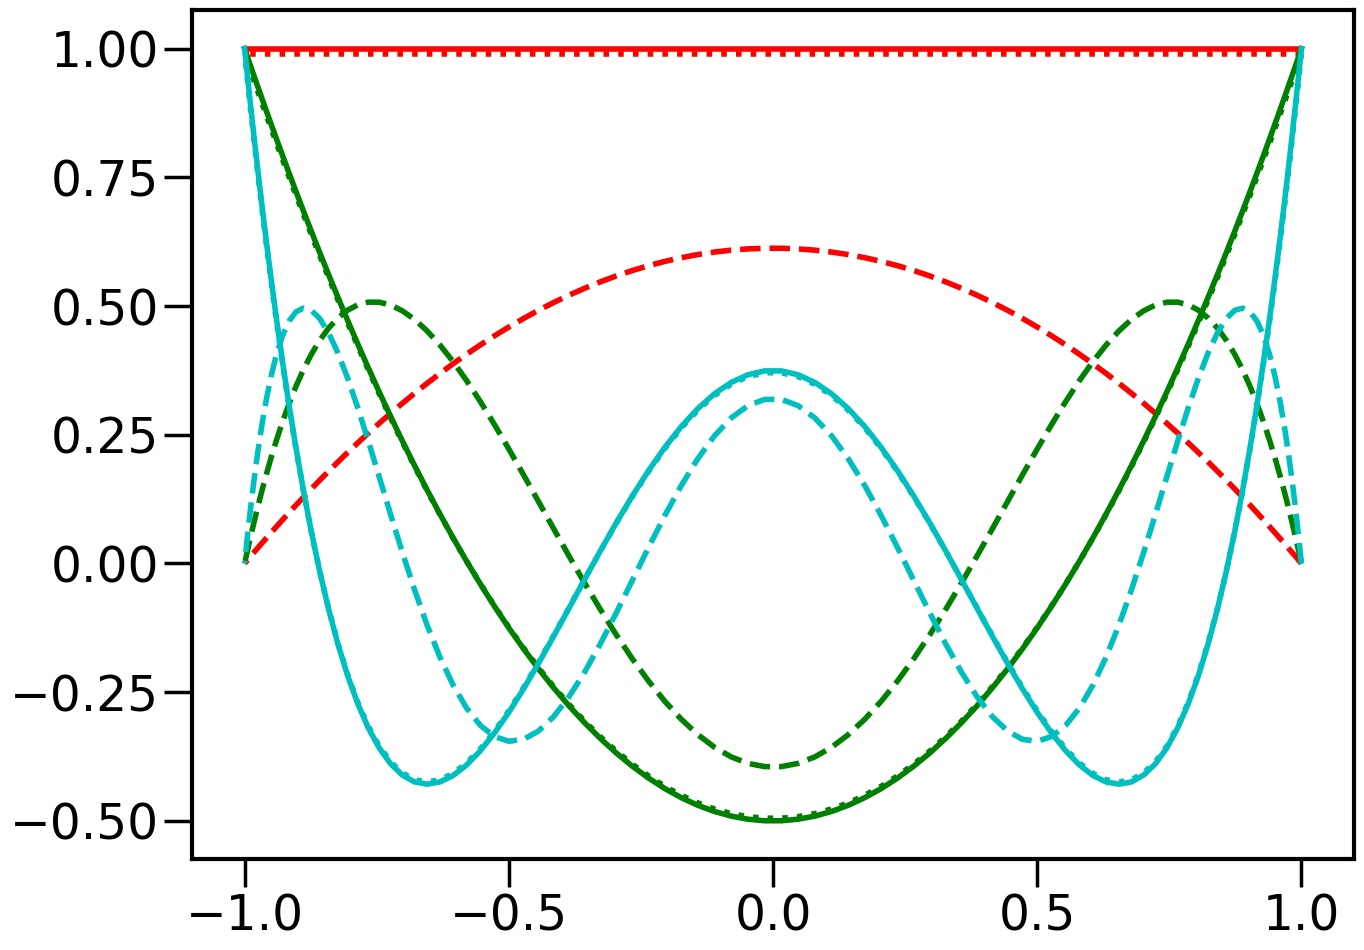

In [15]:
colors=['r','b','g','m','c']
for order in orders:
    plot(mu,L[order],color=colors[order])
    plot(mu,W0[order]*.99,':',color=colors[order])
    plot(mu,W[order],'--',color=colors[order])

In [16]:
j_nu=2

In [17]:
rp=np.linspace(.1,100,500)
pi=np.linspace(0,100,499)
pi2=np.append(-pi[::-1],pi)

# kp=np.logspace(np.log10(kmin),np.log10(kmax),18000)
# kz=np.logspace(np.log10(kmin),np.log10(kmax),18001)

kp=np.linspace(kmin,kmax,18000)
kz=np.linspace(kmin,kmax,18001)

In [25]:
xi_rp_pi_pcr=pcr.xi_rp_pi(f=0.66,bg1=2,pk=pk,l=[2,4],spin=2,rp=rp,pi=pi2)

2 [2, 4] -1 0.33 -0.9999995000003751 0.9999995000003751


In [26]:
xi_rp_pi_pcr

array([[7.65432260e-09, 6.89794714e-08, 1.91652480e-07, ...,
        1.59650185e-03, 1.59494585e-03, 1.59336654e-03],
       [7.72659203e-09, 6.96307362e-08, 1.93461869e-07, ...,
        1.60328119e-03, 1.60171564e-03, 1.60012648e-03],
       [7.79989971e-09, 7.02913640e-08, 1.95297308e-07, ...,
        1.61008713e-03, 1.60850155e-03, 1.60690274e-03],
       ...,
       [7.79989971e-09, 7.02913640e-08, 1.95297308e-07, ...,
        1.61008713e-03, 1.60850155e-03, 1.60690274e-03],
       [7.72659203e-09, 6.96307362e-08, 1.93461869e-07, ...,
        1.60328119e-03, 1.60171564e-03, 1.60012648e-03],
       [7.65432260e-09, 6.89794714e-08, 1.91652480e-07, ...,
        1.59650185e-03, 1.59494585e-03, 1.59336654e-03]])

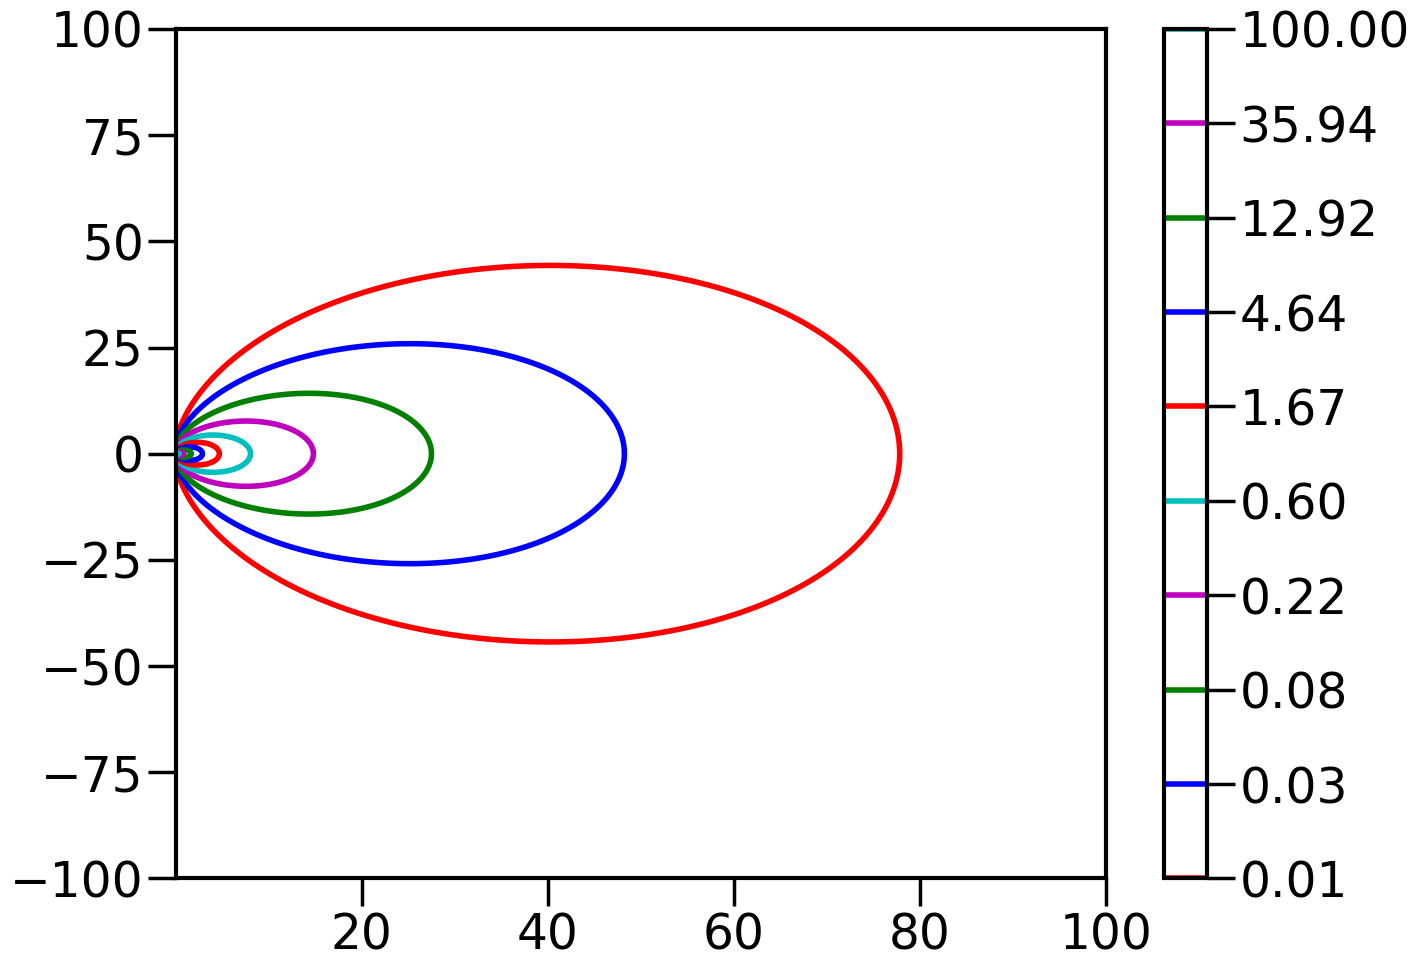

In [29]:
if j_nu==0:
    ll=np.logspace(2,4,10)
else:
    ll=np.logspace(-2,2,10)
# ll=np.linspace(0.1,1000,10)
contour(rp,pi2,xi_rp_pi_pcr,levels=ll,colors=colors)
# xscale('log')
# yscale('log')
colorbar()

In [ ]:
crash

In [ ]:
k=np.sqrt(kp[:,None]**2+kz[None,:]**2)

In [ ]:
pk_intp=interp1d(kh,pk,bounds_error=False,fill_value=0)

In [ ]:
pk_g=pk_intp(k)


In [ ]:
beta=0.66/1.8
mu=kz[None,:]/k

In [ ]:
if j_nu==2:
#     pk_g/=k**2
    pk_g*=(1+beta*mu**2)/k**2
else:
#     pass
    pk_g*=(1+beta*mu**2)**2

In [ ]:
kz_pi=np.cos(kz[:,None]*pi[None,:])*np.gradient(kz)[:,None]
# pi_max=np.atleast_1d(300)
# kz_pi=np.sin(kz[:,None]*pi_max[None,:])*np.gradient(kz)[:,None]/kz[:,None]

In [ ]:
pk_kp=pk_g@kz_pi

In [ ]:
kp_rp=jn(j_nu,kp[:,None]*rp[None,:])*np.gradient(kp)[:,None]*(kp**(j_nu+1))[:,None]

In [ ]:
xi_rp_pi=kp_rp.T@pk_kp

In [ ]:
w_rp=kp_rp.T@pk_intp(kp)

In [ ]:
if j_nu==0:
    ll=np.logspace(0,3,10)
else:
    ll=np.logspace(-2,2,10)
# ll=np.linspace(0.1,1000,10)
contour(rp,pi,xi_rp_pi.T,levels=ll,colors=['r','b','g','m','c'])
xscale('log')
# yscale('log')
colorbar()

In [ ]:
xi_rp_pi.shape

In [ ]:
# plot(rp,xi_rp_pi@np.gradient(pi))
plot(rp,w_rp)
plot(rp,xi_rp_pi[:,0])
loglog()

In [ ]:
r=np.logspace(-1,np.log10(50),1000)
mu=np.linspace(-1,1,999)

rr,muu=np.meshgrid(r,mu)

theta=np.arccos(muu)
rpb=np.sin(theta)*rr
pib=np.cos(theta)*rr

In [ ]:
pi_indx=np.digitize(np.absolute(pib),bins=pi)-1
rp_indx=np.digitize(rpb,bins=rp)-1

In [ ]:
xx=pi_indx<0
xx2=rp_indx<0

In [ ]:
xi_r_mu=xi_rp_pi[rp_indx,pi_indx]

In [ ]:
xi_r_mu[xx]*=0
xi_r_mu[xx2]*=0

In [ ]:
colors=['y','c','r','b','m','g','k','gray']

In [ ]:
if j_nu==0:
    ll=np.logspace(2,4,10)
else:
    ll=np.logspace(-2,2,10)
# ll=np.linspace(0.1,1000,10)
contour(rr,muu,xi_r_mu,levels=ll,colors=colors)
xscale('log')
# yscale('log')
colorbar()

In [ ]:
theta.shape

In [ ]:
wigner_d(2,0,theta[:,0],2,l_use_bessel=None).shape

In [ ]:
orders=[0,2,4,6]
W={order:wigner_d(2,0,theta[:,0],order)[:,0] for order in orders}
W0={order:wigner_d(0,0,theta[:,0],order)[:,0] for order in orders}

In [ ]:
r2,xi2=pcr.get_xi_multipole(pk=pk,l=[0,2,4,6])

In [ ]:
r.shape

In [ ]:
W[0].shape,xi_r_mu.shape

In [ ]:
order=0
f=r**2
plot(r,f*(np.gradient(mu)*W[order]@xi_r_mu),':')
# plot(r,f*(xi_r_mu.T@W0[order]),'--')
plot(r,f*(np.gradient(mu)*W0[order]@xi_r_mu)*1.e-1,'--')

f=r2[order]**2
plot(r2[order],f*xi2[order])
# plot(r2[4],xi2[4][0]*1e2)
xlim(.1,10)
# ylim(-1e0,1e6)
xscale('log')
# yscale('log')
show()

In [ ]:
order=2
f=r**2
plot(r,f*(np.gradient(mu)*W[order]@xi_r_mu)*5.1,':')
# plot(r,f*(xi_r_mu.T@W0[order]),'--')
plot(r,f*(np.gradient(mu)*W0[order]@xi_r_mu)*-11.1,'--')

f=r2[order]**2
plot(r2[order],f*xi2[order]*7e1*-1)
# plot(r2[4],xi2[4][0]*1e2)
xlim(1,100)
xscale('log')
show()

In [ ]:
order=4
f=r**2
plot(r,f*(np.gradient(mu)*W[order]@xi_r_mu)*1.73*-1,':')
# plot(r,f*(xi_r_mu.T@W0[order]),'--')
plot(r,f*(np.gradient(mu)*W0[order]@xi_r_mu)*2.77,'--')

f=r2[order]**2
plot(r2[order],f*xi2[order])
# plot(r2[4],xi2[4][0]*1e2)

xscale('log')
xlim(1,100)
show()